# Problem : Clustering the listings based on non-null text features i.e names, description, property_type and room_type
- We hope to help those traveller wish to rent the listings filter the choices through text features and also they can choose the listings based on the wordclouds which show the top 30 words that characterize each cluster.
- Task:Clustering the listings on text

- Performance measure:Use some metrics provided in sklearn which can measure the performance of K-means learning without ground truth

- Experience: non-null text features data in listings dataset

# Import all the libraries needed

In [2]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, MiniBatchKMeans  # MiniBatchKMeans really helps to fasten processing time
from nltk import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
import math as math
import nltk
import folium
nltk.download('wordnet')
nltk.download('omw-1.4')
sns.set_style("whitegrid")
#plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
sns.color_palette("tab10")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/abhijitverma/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/abhijitverma/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Define custom lemmatizer which will be used during tranformatting the text into tfidf format

In [3]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self,doc):
        return [self.wnl.lemmatize(t) for t in wordpunct_tokenize(doc) if len(t.strip()) > 1]

## Preprocessing of listings.csv
- Convert price column to numerical
- Remove outliers of price column and plot the boxplot
- Combine all the non-null text features into one column

[Text(0.5, 1.0, 'Box Plot of Price ($)')]

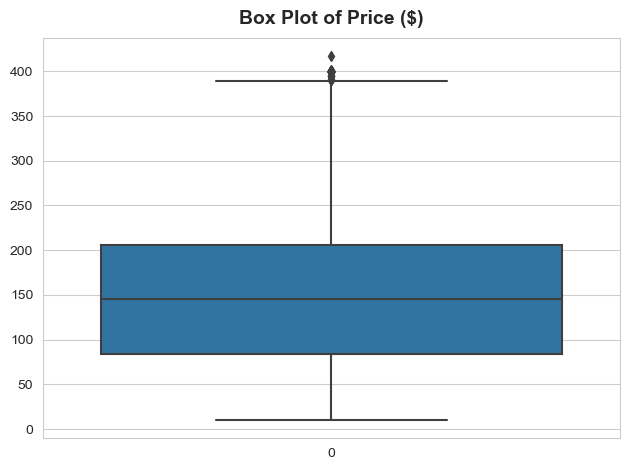

In [4]:
df = pd.read_csv('./listings.csv')
price_cols_index = df.columns[df.columns.str.contains('price') == True]
for variable in price_cols_index:
    df[variable] = df[variable].map(lambda x: x.replace("$",'').replace(",",''),
                                                na_action = 'ignore')
    df[variable] = df[variable].astype(float)
Q1 = df["price"].quantile(0.25)
Q3 = df["price"].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df["price"] < (Q1 - 1.5 * IQR)) |(df["price"] > (Q3 + 1.5 * IQR)))]
Y = df["price"]
sns.boxplot(data=Y).set(title="Box Plot of Price ($)")

The box plot of the "price" data indicates a moderate spread in prices with the median slightly skewed towards lower values, suggesting a slight skew towards higher prices. There are no visible outliers, likely due to earlier removal of extreme values. Overall, the plot reveals a relatively symmetric distribution with a reasonable variability in price data.

## Combine the text features

In [5]:
df['combined_description'] = df.apply(lambda x: '{} {} {} {}'.format(x['name'], x['property_type'], x['description'], x['room_type']), axis=1)
print(df.loc[0,'combined_description'])

Sunny Bungalow in the City House Cozy, sunny, family home.  Master bedroom high ceilings. Deck, garden with hens, beehives & play structure.   Short walk to charming village with  attractive stores, groceries & local restaurants. Friendly neighborhood. Access public transportation. The house has an open and cozy feel at the same time.  The living room has a flat screen TV.  The kitchen has all you need for cooking.  We prefer you buy your food but can use the organic oils, herbs, etc.   The yard can be seen from sitting room and when the weather allows, the yard is a place children can lose themselves in a safe way.  We have 2 bee hives, 6 hens fenced in (sometimes they get out of their coop area & into the yard), 2 rabbits in a hutch and play structure. You will have access to 2 bedrooms, a living room, kitchen, bathrooms, and yard. Roslindale is quiet, convenient and friendly.  For Southern food try Redd's in Rozzie.  Italian Delfino's or Sophia's Grotto are great. Birch St Bistro ha

## Transform the combined feature into tfidf format

In [6]:
tfidf = TfidfVectorizer(ngram_range=(1,2),stop_words='english',tokenizer=LemmaTokenizer())
tfidf.fit(df['combined_description'])
DescTfidf = tfidf.transform(df['combined_description'])

/Users/abhijitverma/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/abhijitverma/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


## Visualize the number of listings in each neighbourhood

Text(0.5, 1.0, 'Number of Listings in Each Neighbourhood')

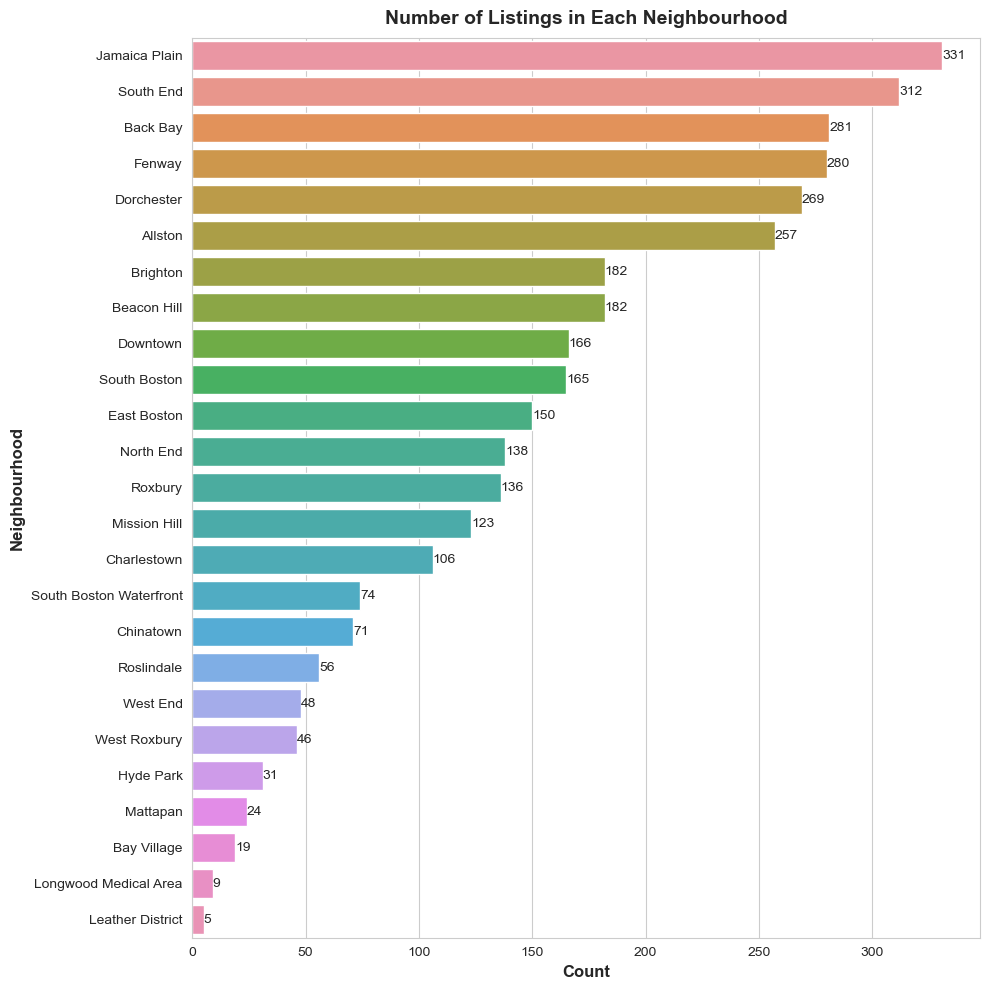

In [7]:
neighborRank = df.groupby(by='neighbourhood_cleansed').count().sort_values(by="id", ascending=False)
plt.figure(figsize=(10,10))
bar = sns.barplot(y=neighborRank.index,x=neighborRank["id"])
plt.xlabel("Count")
plt.ylabel("Neighbourhood")
bar.bar_label(bar.containers[0])
plt.title('Number of Listings in Each Neighbourhood')

The bar plot above shows the number of listings in each neighbourhood, sorted in descending order of the count. Jamaica Plain: 331 listings, South End: 312 listings, Back Bay: 281 listings, Fenway: 280 listings, Dorchester: 269 listings neighbourhoods represent the areas with the most significant number of listings in the dataset, indicating their popularity or demand in the property market. 

# K-means algorithm
KNN is used for supervised learning problem,and the K-means is designed for unspervised 
- Use elbow method to decide optimum K
- Use some metrics provided in sklearn which can measure the performance of K-means learning without ground truth to choose the best K
- Plot the relationship between the metrics and the K

# Comparsion between KNN and K-means
- KNN is used for supervised learning problem,and the K-means is designed for unsupervised
- The meaning of K in KNN: When a sample x comes, it should be classified, that is, its y should be calculated, and K data points nearest to it should be found from the data set. For these K data points, the category c accounts for the largest number, so the label of x should be set to c.Meaning of K in K-Means: K is a manually fixed number. It is assumed that the data set can be divided into K clusters. Since it is manually determined, a little prior knowledge is required.


Current Number of Cluster : 2
Done fitting...
Current Number of Cluster : 3
Done fitting...
Current Number of Cluster : 4
Done fitting...
Current Number of Cluster : 5
Done fitting...
Current Number of Cluster : 6
Done fitting...
Current Number of Cluster : 7
Done fitting...
Current Number of Cluster : 8
Done fitting...
Current Number of Cluster : 9
Done fitting...
Current Number of Cluster : 10
Done fitting...


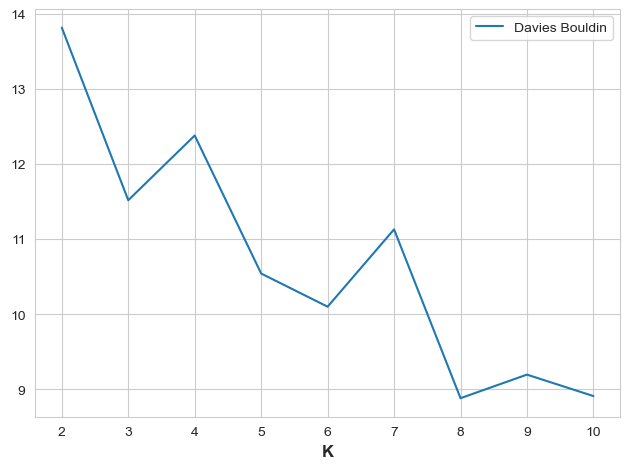

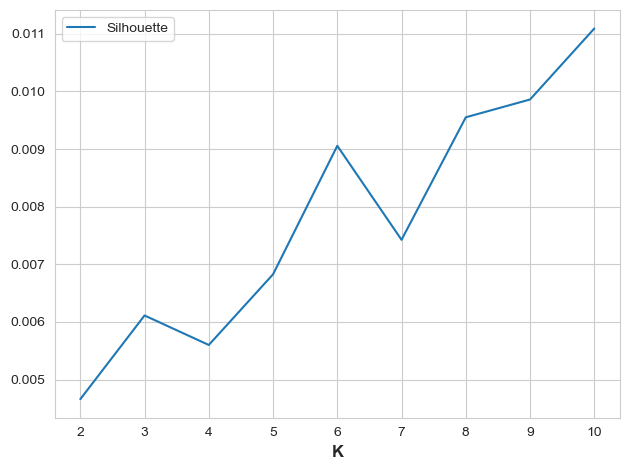

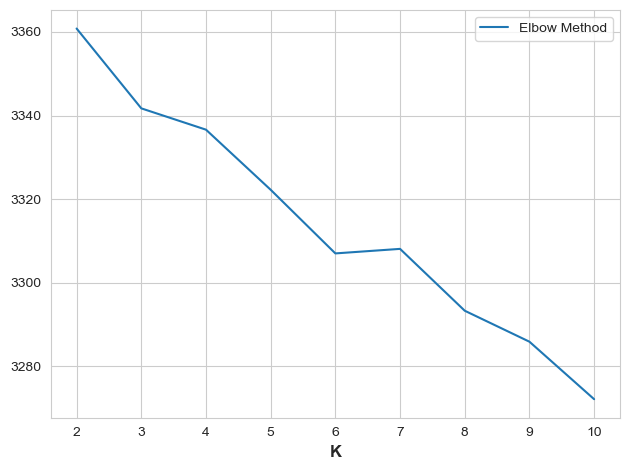

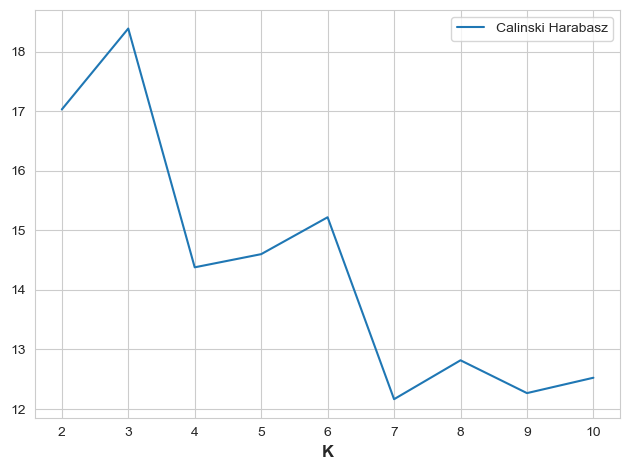

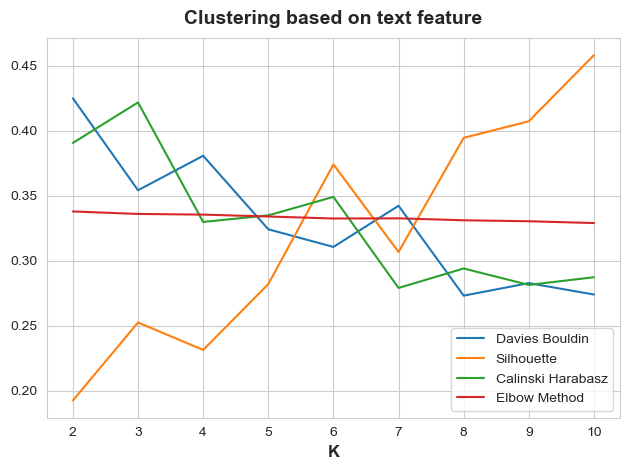

In [8]:
db_score, s_score, ch_score = [], [], []
inertia = []
dense_array = np.asarray(DescTfidf.todense())
for n in range(2, 11):
    print(f"Current Number of Cluster : {n}")
    kmeans = MiniBatchKMeans(n_clusters=n).fit(dense_array)

    print("Done fitting...")
    labels = kmeans.labels_
    db_score.append(davies_bouldin_score(dense_array, labels)) # Low implies well
    s_score.append(silhouette_score(dense_array, labels)) # High implies well
    ch_score.append(calinski_harabasz_score(dense_array, labels)) # High implies well
    inertia.append(kmeans.inertia_) # Low implies well
    
plt.figure()
plt.plot([n for n in range(2, 11)], db_score, label="Davies Bouldin")
plt.xlabel("K")
plt.legend()
plt.show()

plt.figure()
plt.plot([n for n in range(2, 11)], s_score, label="Silhouette")
plt.xlabel("K")
plt.legend()
plt.show()

plt.figure()
plt.plot([n for n in range(2, 11)], inertia, label="Elbow Method")
plt.xlabel("K")
plt.legend()
plt.show()

plt.figure()
plt.plot([n for n in range(2, 11)], ch_score, label="Calinski Harabasz")
plt.xlabel("K")
plt.legend()
plt.show()

# print(db_score, s_score, ch_score, inertia)
db_score = sklearn.preprocessing.normalize([db_score])    
s_score = sklearn.preprocessing.normalize([s_score])
ch_score = sklearn.preprocessing.normalize([ch_score])
inertia = sklearn.preprocessing.normalize([inertia])

plt.figure()
plt.title("Clustering based on text feature")
plt.plot([n for n in range(2, 11)], db_score[0, :], label="Davies Bouldin")
plt.plot([n for n in range(2, 11)], s_score[0, :], label="Silhouette")
plt.plot([n for n in range(2, 11)], ch_score[0, :], label="Calinski Harabasz")
plt.plot([n for n in range(2, 11)], inertia[0, :], label="Elbow Method")
plt.xlabel("K")
plt.legend()
plt.show()



# Perform the K-Means using the optimal K

In [9]:
n_clusters = 10
kmeans = MiniBatchKMeans(n_clusters=n_clusters).fit(dense_array)
X = df[["combined_description", "neighbourhood_cleansed", "price"]]
X["cluster"] = kmeans.labels_

/var/folders/jd/1jzp59615_ng5jq0zqr1hkkr0000gn/T/ipykernel_1070/3203236742.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["cluster"] = kmeans.labels_


## Fill the null values in review scores columns and calculate the mean of overall review scores for each cluster

In [11]:
df["review_scores_rating"].fillna(0, inplace=True)
df["review_scores_value"].fillna(0, inplace=True)
df["review_scores_accuracy"].fillna(0, inplace=True)
df["review_scores_cleanliness"].fillna(0, inplace=True)
df["review_scores_checkin"].fillna(0, inplace=True)
df["review_scores_communication"].fillna(0, inplace=True)
df["review_scores_location"].fillna(0, inplace=True)

df["overall_review_scores"] = (df["review_scores_rating"] / 10 + df["review_scores_value"] + df["review_scores_accuracy"] +
                              df["review_scores_cleanliness"] + df["review_scores_checkin"] + df["review_scores_communication"]+
                              df["review_scores_location"]) / 7

Y = pd.concat([X, df["overall_review_scores"]], axis=1)
mean_review_score = Y.groupby("cluster")["overall_review_scores"].mean()
mean_review_score

cluster
0    6.733613
1    8.130584
2    9.471429
3    6.903310
4    5.931850
5    7.616311
6    6.536697
7    5.444858
8    4.070000
9    6.333275
Name: overall_review_scores, dtype: float64

These scores indicate the average overall satisfaction of guests across various aspects of their stay, such as cleanliness, check-in process, accuracy of listing, etc., for each cluster. Clusters 2 and 1 have notably higher average review scores, suggesting that listings in these clusters are generally well-received by guests. In contrast, Clusters 8 and 7 have lower average scores, indicating potential areas for improvement or specific challenges faced by listings in these clusters. 

## Calculate the mean price for each cluster

In [12]:
mean_price = X.groupby('cluster')["price"].mean()
mean_price

cluster
0    152.372549
1    192.574648
2    125.000000
3    211.868564
4    279.934426
5    109.807263
6     95.770642
7    129.159533
8    197.600000
9    236.451220
Name: price, dtype: float64

These figures represent the average price per listing within each cluster. The variation in average prices across clusters suggests differences in the types of properties or amenities offered. For example, clusters 4 and 9 have the highest average prices, which might indicate these clusters include more upscale or luxury properties. In contrast, clusters 6 and 5 have the lowest average prices, possibly representing more budget-friendly or basic accommodations.

## Visualize the number of listings in each cluster

Text(0, 0.5, 'Mean Overall Review Scores')

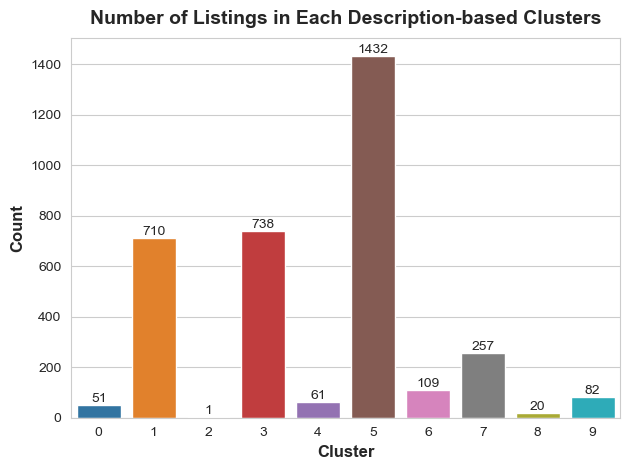

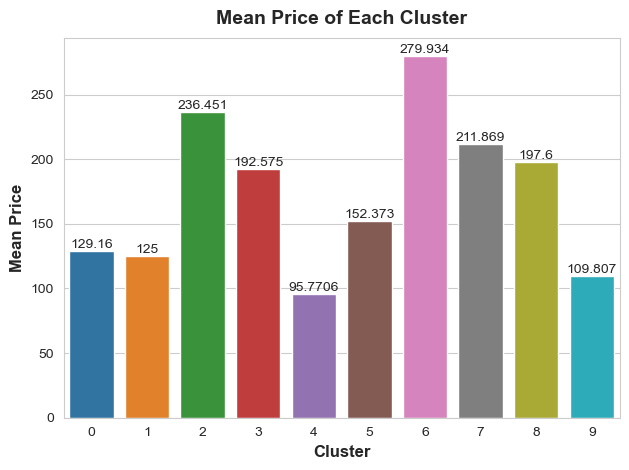

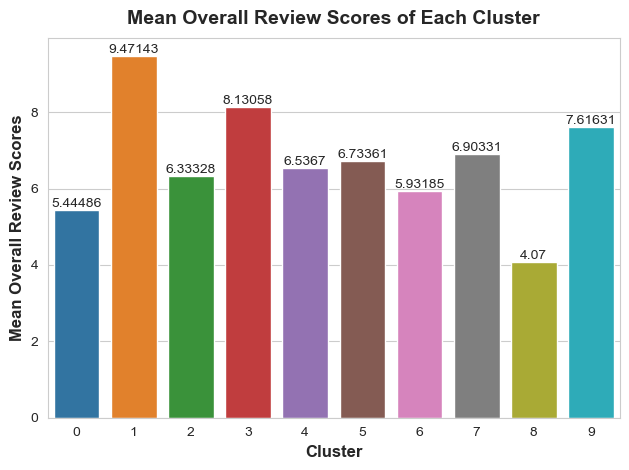

In [13]:
ClusterCount = X['cluster'].value_counts().sort_index()
ClusterCount = pd.DataFrame(ClusterCount)
ClusterCount.columns=['NumListings']
bar = sns.barplot(x=X['cluster'].value_counts().index,y=X['cluster'].value_counts())
bar.bar_label(bar.containers[0])
plt.title('Number of Listings in Each Description-based Clusters')
plt.xlabel("Cluster")
plt.ylabel("Count")

plt.figure()
bar_price = sns.barplot(x=X["cluster"].value_counts().index, y=mean_price)
bar_price.bar_label(bar_price.containers[0])
plt.title("Mean Price of Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Mean Price")

plt.figure()
bar_review_score = sns.barplot(x=X["cluster"].value_counts().index, y=mean_review_score)
bar_review_score.bar_label(bar_review_score.containers[0])
plt.title("Mean Overall Review Scores of Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Mean Overall Review Scores")


## Visualize the number of listings of each cluster in neighbourhood

Text(0.5, 1.0, 'Crosstab of Cluster and Neighbourhood')

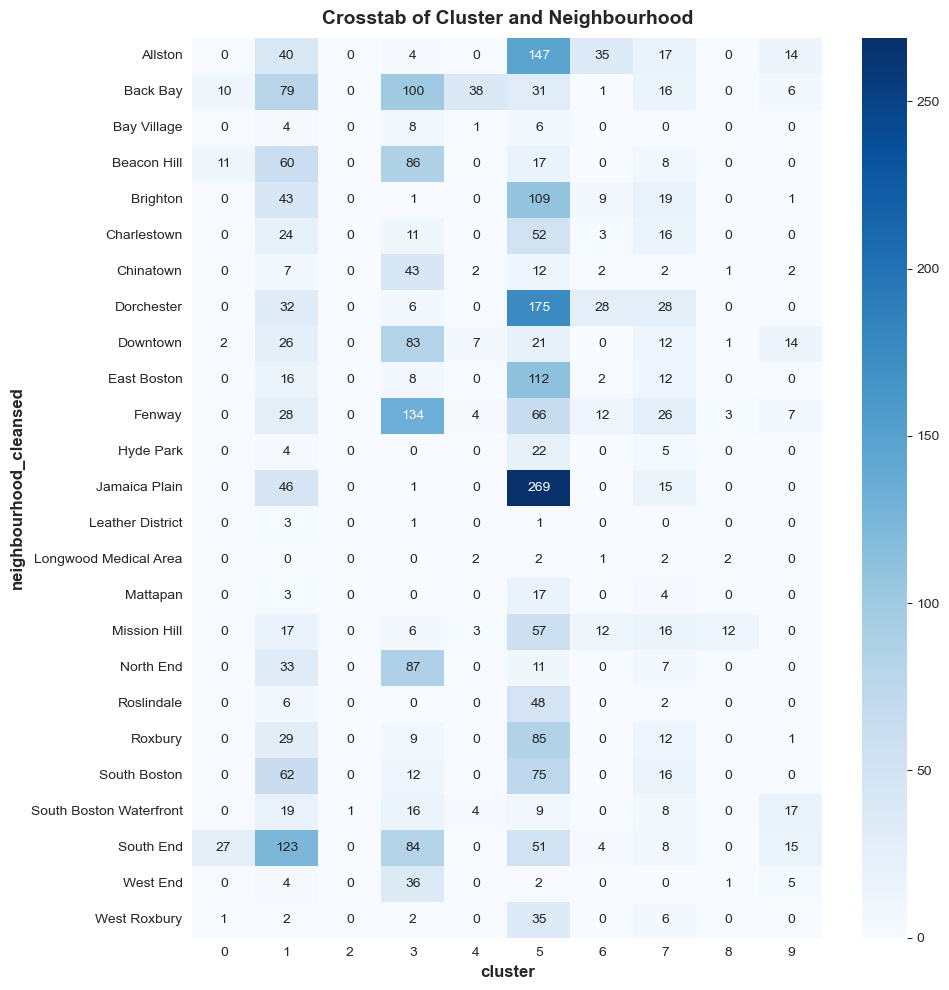

In [14]:
ctab = pd.crosstab(index=X['neighbourhood_cleansed'],columns=X['cluster'])
plt.figure(figsize=(10,10))
sns.heatmap(ctab,annot=True,cmap='Blues', fmt='g')
plt.title("Crosstab of Cluster and Neighbourhood")

## Define function that return top $n^{th}$ features that characterize each cluster

In [15]:
def show_topn(classifier, vectorizer, categories,n):
    feature_names = np.asarray(vectorizer.get_feature_names_out())
    for i, category in enumerate(categories):
        topn = np.argsort(classifier.coef_[i])[-n:]
        print('{}: {}'.format(category,", ".join(feature_names[topn])))
        
def save_topn(classifier, vectorizer, num_clusters:int, top_n_words:int, outdict):
    feature_names = np.asarray(vectorizer.get_feature_names_out())
    for idx in range(num_clusters):
        topn = np.argsort(classifier.coef_[idx])[-top_n_words:]
        outdict[idx] = feature_names[topn]

## Identify the top 30 words that are "best predictor" of each cluster and visualize them using wordcloud

In [19]:
pipeline = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2), stop_words='english', tokenizer=LemmaTokenizer())),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                              alpha=1e-3, max_iter=5, random_state=42)),
])
modelSegment = pipeline.fit(df['combined_description'],X['cluster'])

Keywords = {}
save_topn(modelSegment.named_steps['clf'], modelSegment.named_steps['tfidf'], 
          n_clusters, 30, outdict=Keywords)

/Users/abhijitverma/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
/Users/abhijitverma/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


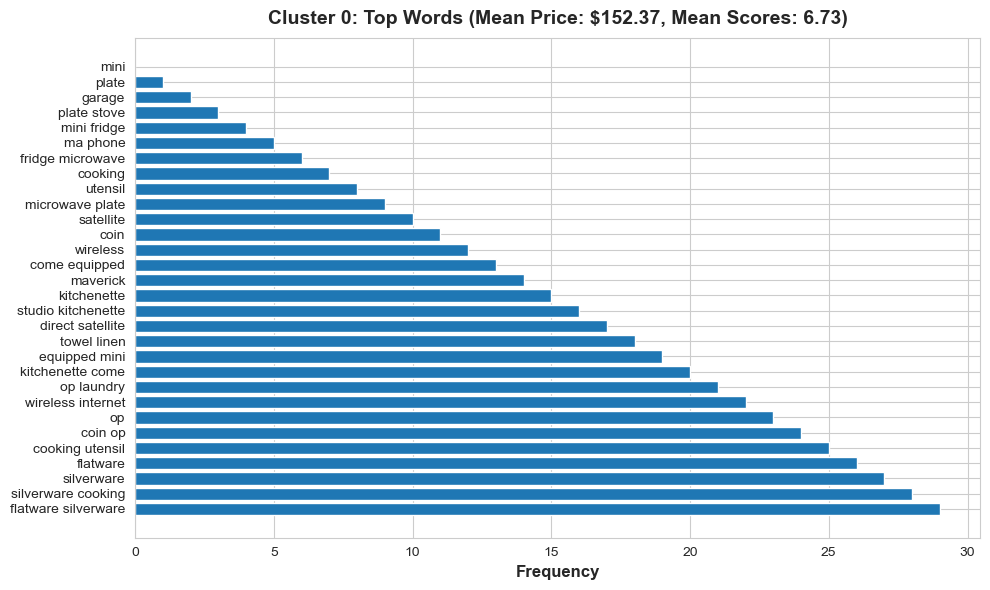

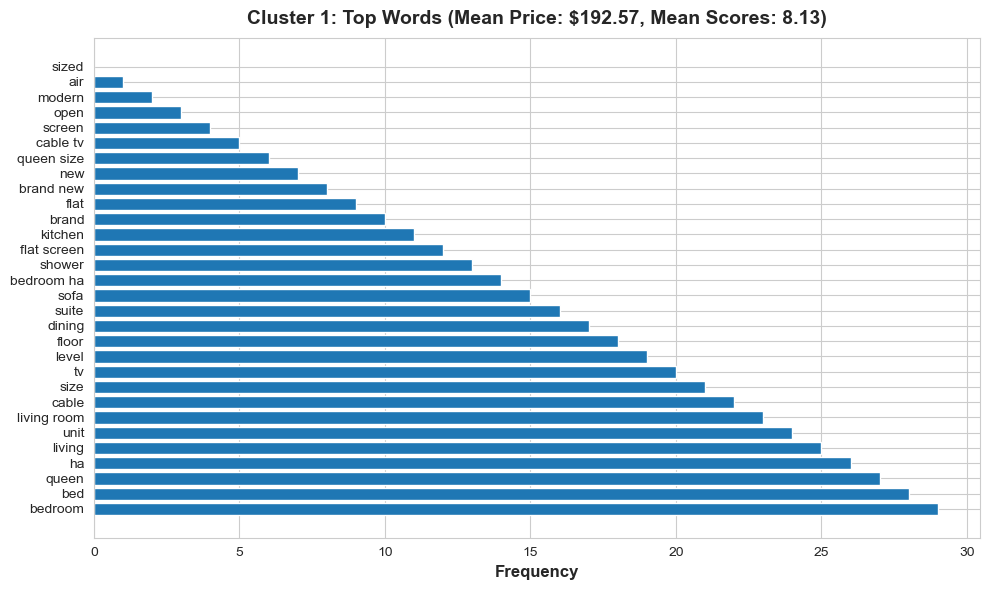

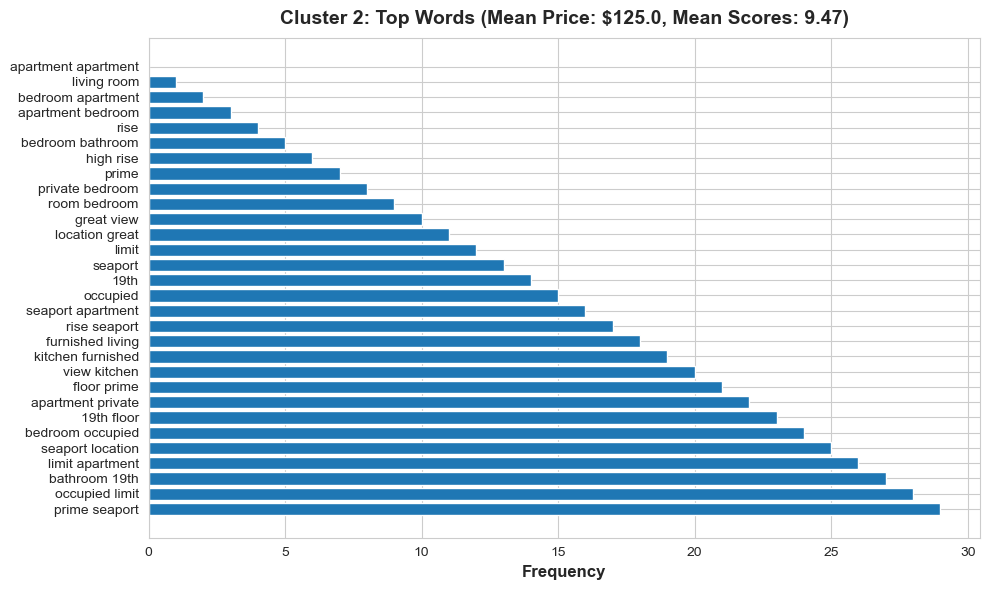

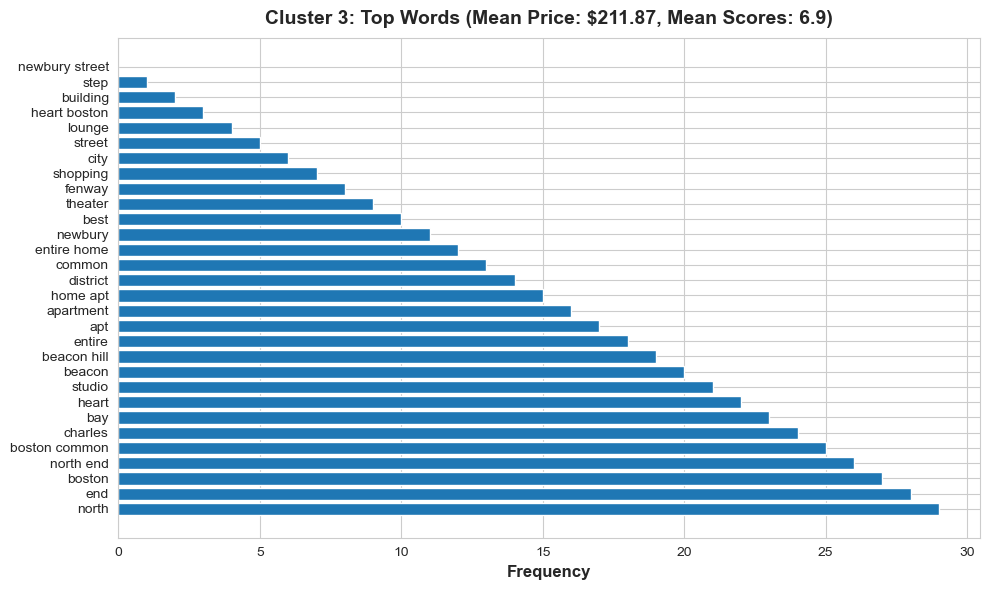

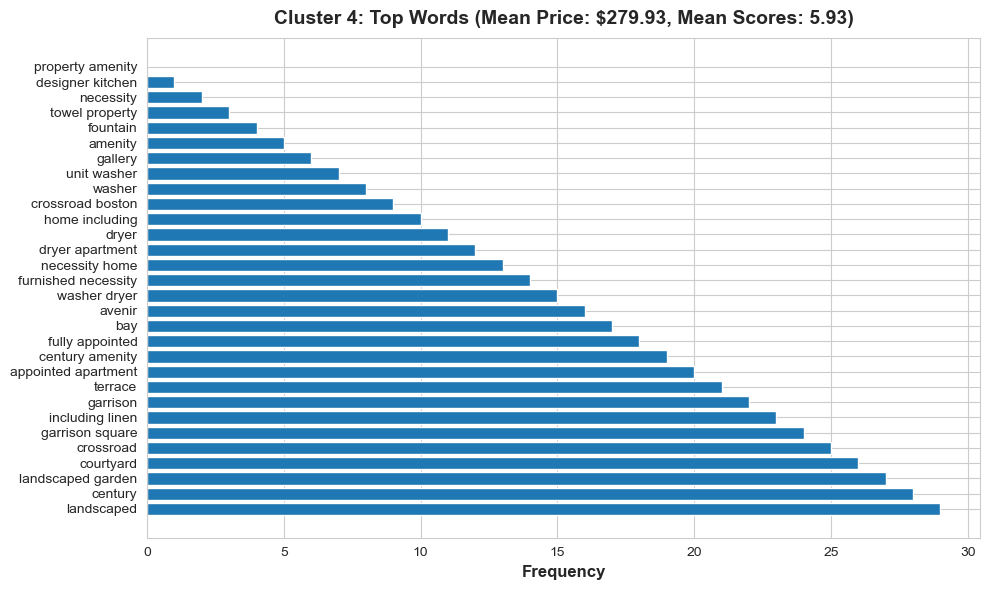

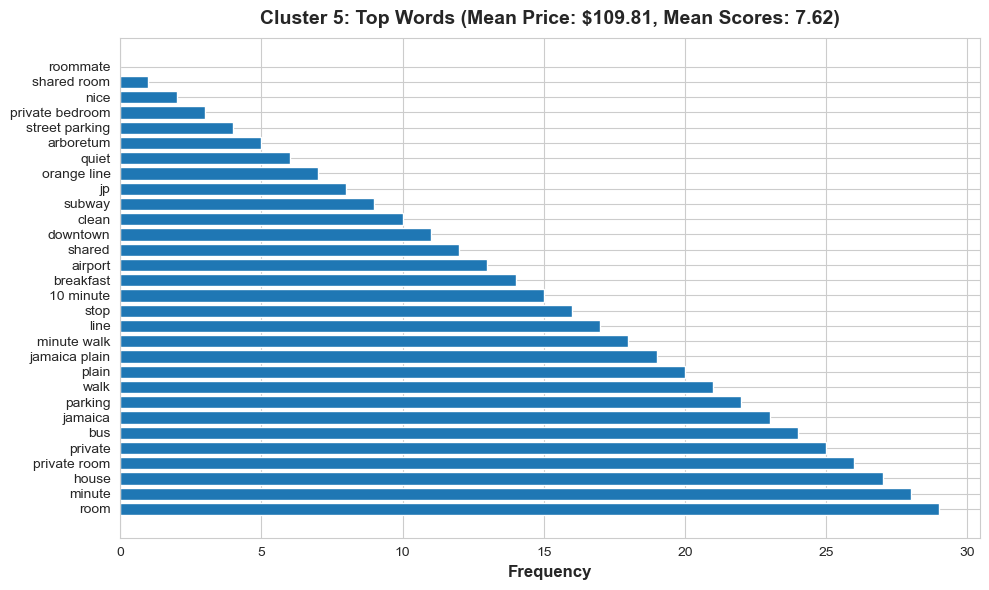

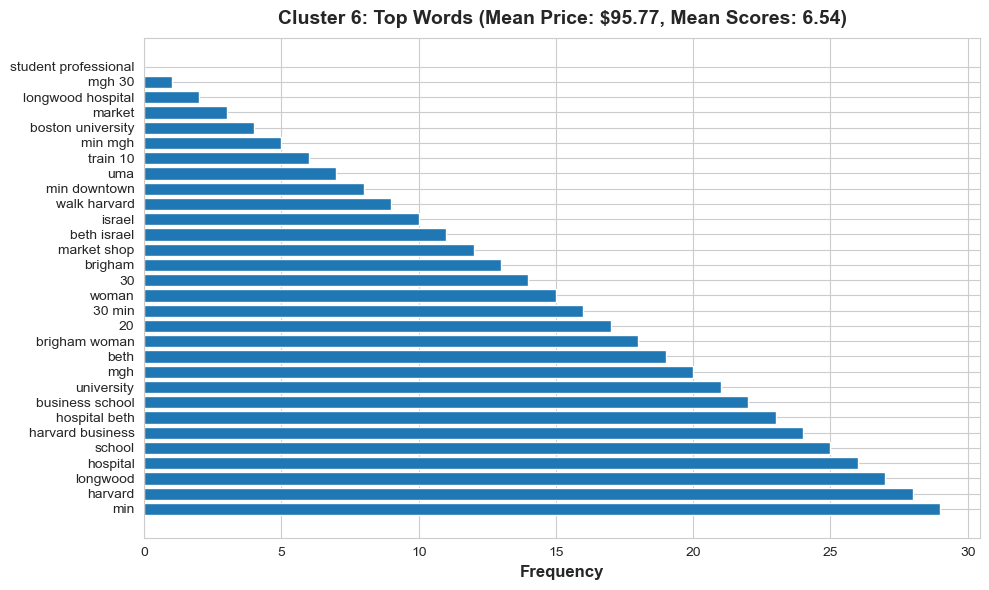

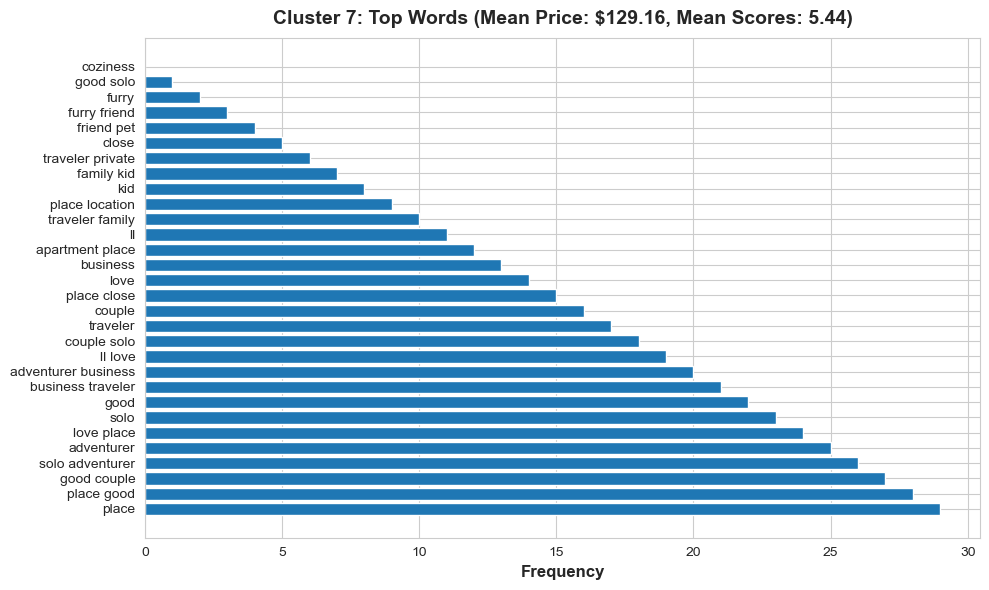

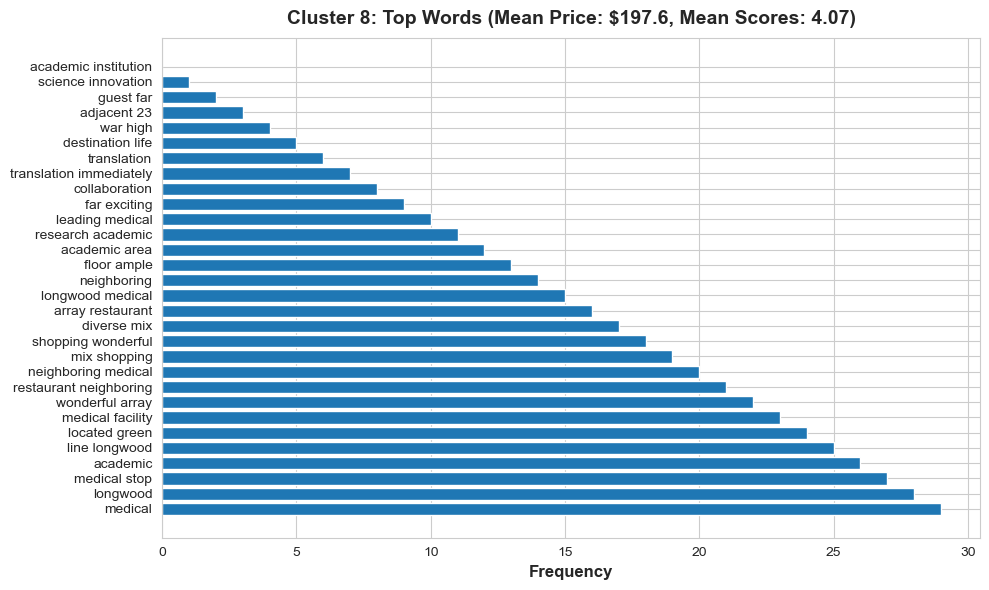

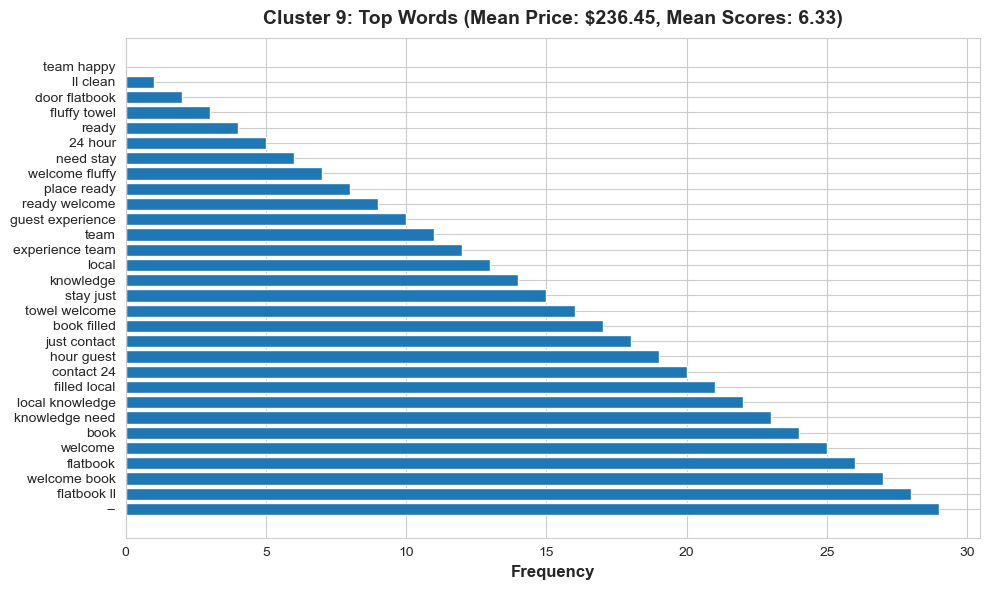

In [20]:
# Creating horizontal bar charts for the most frequent words in each cluster

for i in range(n_clusters):
    # Extracting the top words for each cluster
    wordlist = list(Keywords[i])

    # Plotting the top words in a horizontal bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(wordlist, range(len(wordlist)))  # Horizontal bar chart
    plt.xlabel("Frequency")
    plt.title(f"Cluster {i}: Top Words (Mean Price: ${round(mean_price[i], 2)}, Mean Scores: {round(mean_review_score[i], 2)})")
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency words on top
    plt.show()


## Plot the points and show the mean price and mean overall review scores of each clustering

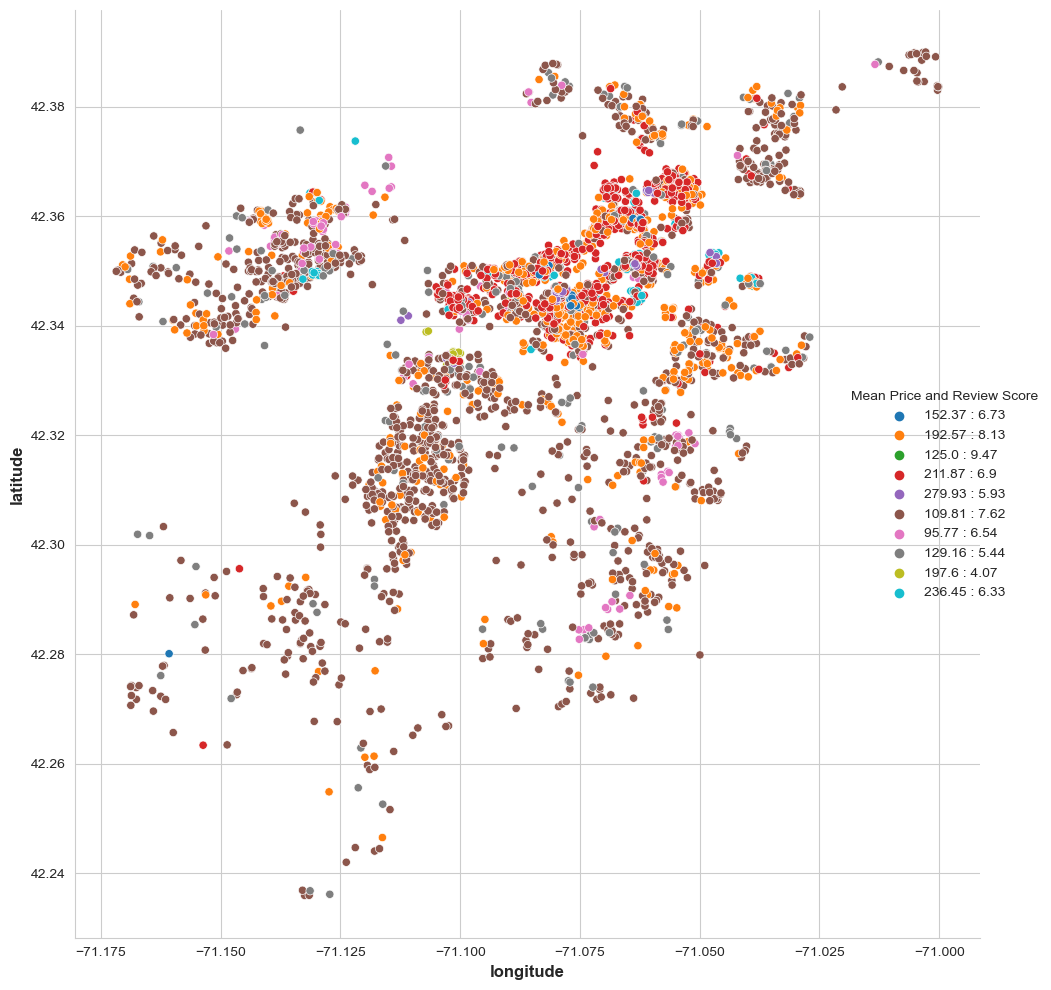

In [21]:
geo = pd.concat([X, df["latitude"], df["longitude"]], axis=1)
colors = {0 : 'blue', 1 : 'orange', 2 : "green", 3 : "red", 
          4 : "purple", 5:"brown", 6:"pink", 
          7:"grey", 8:"gold", 9:"yellow"
         }
s = sns.relplot(
    x="longitude", y="latitude", hue="cluster", data=geo, height=10,
    palette=sns.color_palette("tab10")
)


new_title = 'Mean Price and Review Score'
s._legend.set_title(new_title)
mean_price = X.groupby("cluster")["price"].mean().round(2)
mean_review_score = Y.groupby("cluster")["overall_review_scores"].mean().round(2)
for t, p, s in zip(s._legend.texts, mean_price, mean_review_score):
    t.set_text(f"{p} : {s}")

The provided scatter plot illustrates the distribution of property listings in a certain geographic area, categorized into clusters that are differentiated by color. Each color-coded cluster corresponds to a grouping of listings with similar characteristics and is annotated with two key metrics: mean price and mean overall review score.

Key observations from the image:

- The orange cluster, for example, with a mean price of 192.57 and a high mean review score of 8.13, suggests that listings in this cluster are generally well-regarded by guests and may offer good value for money.
- In contrast, the red cluster shows a relatively high mean price of 211.87 but a lower mean review score of 6.9. This could indicate premium listings that may not fully meet guest expectations or have specific drawbacks.
- The pink cluster stands out with the lowest mean price (95.77) and a moderate mean review score (6.54), possibly representing budget accommodations that offer satisfactory service or amenities.
- The blue cluster has a higher mean price of 236.45 but a mean review score of 6.33, which could point to upscale properties with room for service or quality improvements.
- The gray cluster has the lowest mean review score (4.07) despite a mid-range mean price (197.6), indicating a potential mismatch between price and guest satisfaction.

## Plot the listings on the actual map

In [22]:
colors = {0 : 'blue', 1 : 'orange', 2 : "green", 3 : "red", 
          4 : "purple", 5:"brown", 6:"pink", 
          7:"grey", 8:"gold", 9:"lightblue"
         }
la_mean = geo["latitude"].mean()
lo_mean = geo["longitude"].mean()

map_osm = folium.Map(location=[la_mean, lo_mean], zoom_start=14)

geo.apply(lambda row:folium.CircleMarker(
    location=[row["latitude"], row["longitude"]], 
    radius=6, fill_color=colors[row["cluster"]],  color=colors[row["cluster"]],
    fill=True, fill_opcaity=1.0, opacity=1,
    popup=folium.Popup(f"cluster {row['cluster']}<br>Mean Price : {mean_price[row['cluster']]}<br>Mean Score : {mean_review_score[row['cluster']]}", max_width=500)
).add_to(map_osm), axis=1)

map_osm

## Analyze the words associated with high-cost versus low-cost listings

In [29]:
# Cleaning the 'price' column and convert it to float
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

# Define high and low cost thresholds
price_threshold_high = df['price'].quantile(0.75)
price_threshold_low = df['price'].quantile(0.25)

# Splitting the dataset into high-cost and low-cost listings
high_cost_descriptions = df[df['price'] > price_threshold_high]['description']
low_cost_descriptions = df[df['price'] <= price_threshold_low]['description']

# Initialize TfidfVectorizer for bigrams and trigrams
vectorizer = TfidfVectorizer(ngram_range=(2, 3), stop_words='english', max_features=100)

# Fitting the vectorizer and transforming the descriptions
tfidf_high = vectorizer.fit_transform(high_cost_descriptions)
tfidf_low = vectorizer.fit_transform(low_cost_descriptions)

# Getting the sorted tf-idf scores for high-cost descriptions
sorted_indices_high = tfidf_high.max(0).toarray()[0].argsort()[::-1]
sorted_indices_low = tfidf_low.max(0).toarray()[0].argsort()[::-1]

# Extracting the features (bigrams and trigrams)
features_high = np.array(vectorizer.get_feature_names_out())[sorted_indices_high][:10]
features_low = np.array(vectorizer.get_feature_names_out())[sorted_indices_low][:10]

# Creating DataFrames for high-cost and low-cost features
df_high_cost_features = pd.DataFrame(features_high, columns=['High-Cost Features'])
df_low_cost_features = pd.DataFrame(features_low, columns=['Low-Cost Features'])

df_high_cost_features, df_low_cost_features


(        High-Cost Features
 0                   10 min
 1             minutes away
 2          place good solo
 3       place good couples
 4               place good
 5                good solo
 6    good solo adventurers
 7             minutes walk
 8  minutes downtown boston
 9         minutes downtown,
        Low-Cost Features
 0                  wi fi
 1        private bedroom
 2               red line
 3            living room
 4   conveniently located
 5              queen bed
 6  public transportation
 7           private room
 8        downtown boston
 9          room bathroom)

The bigrams and trigrams associated with high-cost listings seem to emphasize location convenience ("minutes walk", "neighborhood boston"), modern amenities ("wi fi"), and the quality of living spaces ("kitchen living"). The affectionate terms ("love place", "ll love") could imply a more appealing and emotionally engaging description.

On the other hand, low-cost listings appear to focus on practical aspects such as "commuter rail", "public transportation", and "conveniently located". They also emphasize private space ("private room", "private bedroom") and essential features ("queen bed", "room bathroom").

This information can be useful for identifying what aspects are highlighted in listings at different price points, and it may guide hosts in how to craft their property descriptions to attract their target audience.